In this tutorial, we’ll build a [Recurrent Neural Network (RNN)](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) in PyTorch that will classify people’s names by their languages. We assume that the reader has a basic understanding of [PyTorch](https://heartbeat.fritz.ai/introduction-to-pytorch-for-deep-learning-5b437cea90ac) and [machine learning in Python](https://heartbeat.fritz.ai/some-essential-hacks-and-tricks-for-machine-learning-with-python-5478bc6593f2).

At the end of this tutorial, we’ll be able to predict the language of the names based on their spelling. The dataset of names used in this tutorial can be downloaded [here](https://drive.google.com/uc?id=1Aw8EKmAaAJWL1hT6ASGOxCpurT-0oJr1). This tutorial has been adapted from [PyTorch’s](https://pytorch.org/) official docs— check out more about the implementation from these docs.


## Plan of Attack
1. [Data Pre-processing](https://heartbeat.fritz.ai/data-preprocessing-and-visualization-implications-for-your-machine-learning-model-8dfbaaa51423
)
2. Turning the Names into PyTorch Tensors
3. Building the RNN
4. Testing the RNN
5. Training the RNN
6. Plotting the Results
7. Evaluating the Results
8. Predicting on New Names
9. Conclusion

https://heartbeat.fritz.ai/detecting-the-language-of-a-persons-name-using-pytorch-rnn-29a9090c20f2

## Data Pre-processing

As is the case with any machine learning task, we’ll kick off by loading and preparing our dataset. Upon downloading the dataset, we notice that there’s a folder called *names* inside the data folder. It contains text files with surnames in eighteen different languages.

In order to load all the files in one go, we’ll use a Python module known as [*glob*](https://docs.python.org/3/library/glob.html#module-glob). The [glob](https://docs.python.org/3/library/glob.html#module-glob) module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. Results are returned in an arbitrary order. We’ll use it to load all the files in the folder that end with *.txt* .

In [1]:
# Downloading the dataset

!gdown https://drive.google.com/uc?id=1Aw8EKmAaAJWL1hT6ASGOxCpurT-0oJr1

Downloading...
From: https://drive.google.com/uc?id=1Aw8EKmAaAJWL1hT6ASGOxCpurT-0oJr1
To: /content/data (2).zip
2.88MB [00:00, 87.6MB/s]


In [2]:
!unzip '/content/data (2).zip'

Archive:  /content/data (2).zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [3]:
import glob

all_text_files = glob.glob('data/names/*.txt')
print(all_text_files)

['data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt']


Currently the names are in Unicode format. However, we have to convert them to ASCII standard. This will remove the diacritics in the words. For example, the French name Béringer will be converted to Beringer.

In [4]:

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Béringer'))

Beringer


In the next step, we create a dictionary with a list of names for each language.

In [5]:
category_languages = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_text_files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    languages = readLines(filename)
    category_languages[category] = languages

no_of_languages = len(all_categories)
print('There are {} langauages'.format(no_of_languages))

There are 18 langauages


We can view the first fifteen names in the Arabic dictionary as shown below.

In [6]:
print(category_languages['Arabic'][:15])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad']


## Turning the Names into PyTorch Tensors

When working with data in PyTorch, we have to convert it to PyTorch tensors. This is very similar to NumPy arrays. In our case, we have to convert each letter into a torch tensor. This will be a one-hot vector filled with 0s except for a 1 at the index of the current letter. Let’s show how this is done and then convert the letter M to a one-hot vector.

In [0]:
import torch

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor


In [8]:
print(letter_to_tensor('A'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In order to form a single word, we'll have to join several one-hot vectors to form a 2D matrix.

## Building the RNN

When creating a neural network in PyTorch, we use the ***torch.nn.Module***, which is the base class for all neural network modules.* torch.autograd* provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. ***torch.nn.LogSoftmax()*** applies the *Log(Softmax(x))* function to an n-dimensional input Tensor.


In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Testing the RNN
We kick off by creating an instance of the RNN class and passing in the arguments as required.

In [0]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, no_of_languages)

We’d like the network to give us the probability of each language. In order to achieve this, we’ll pass the tensor of the current letter.

In [11]:
input = Variable(letter_to_tensor('D'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

input = Variable(line_to_tensor('Derrick'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)


output.size = torch.Size([1, 18])
tensor([[-2.8571, -2.8087, -2.8412, -2.9712, -2.9487, -3.0029, -2.8894, -2.9170,
         -2.9211, -2.9013, -2.8352, -2.8252, -2.9158, -2.9152, -2.9547, -2.9333,
         -2.7843, -2.8360]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training the RNN
In order to get the likelihood of each category, we use *Tensor.topk* to get the index of the greatest value

In [12]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) 
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Polish', tensor(16))


Next we need a quick way to obtain a name and its output.

In [13]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_languages[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Arabic / line = Awad
category = Spanish / line = Mas
category = Vietnamese / line = Ho
category = Scottish / line = Hay
category = Italian / line = Montanari
category = Italian / line = Alessandri
category = Japanese / line = Matokai
category = Polish / line = Majewski
category = Portuguese / line = Mateus
category = German / line = Reuter


The next step is to define the [loss function](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0) and create an optimizer that will update the parameters of the model according to its gradients. We also specify a learning rate for our model

In [0]:
criterion = nn.NLLLoss()
 
learning_rate = 0.005 
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

We move forward to define a function that will create the input and output tensors, compare the final output to the target output, and finally do back-propagation.

In [0]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [24]:
category_tensor.dim()

1

The next step is to run several examples using this train function as we keep track of the losses for later plotting.

In [0]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


In [26]:
for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 11s) 2.6170 Schoorel / French ✗ (Dutch)
10000 10% (0m 18s) 1.5516 Chi / Chinese ✗ (Korean)
15000 15% (0m 24s) 1.5027 Garza / Spanish ✓
20000 20% (0m 30s) 2.8184 Rusnak / Arabic ✗ (Polish)
25000 25% (0m 36s) 1.4177 Sommer / German ✓
30000 30% (0m 43s) 1.7033 Perrot / French ✓
35000 35% (0m 50s) 0.5661 Seok / Korean ✓
40000 40% (0m 56s) 1.6404 Barron / English ✓
45000 45% (1m 2s) 2.2184 Duval / Irish ✗ (French)
50000 50% (1m 9s) 0.0168 Filipowski / Polish ✓
55000 55% (1m 15s) 0.4603 Kikkert / Dutch ✓
60000 60% (1m 21s) 0.7755 Venn / Dutch ✓
65000 65% (1m 27s) 1.0906 Ma / Korean ✗ (Vietnamese)
70000 70% (1m 34s) 1.3166 Haddad / Arabic ✓
75000 75% (1m 40s) 1.0228 Deniel / French ✓
80000 80% (1m 46s) 3.6726 Schlantz / Spanish ✗ (Czech)
85000 85% (1m 53s) 0.7741 Kurmochi / Japanese ✓
90000 90% (1m 59s) 0.4001 Pierno / Italian ✓
95000 95% (2m 5s) 1.8661 Jewson / Scottish ✗ (English)
100000 100% (2m 11s) 3.2142 Papageorge / French ✗ (Greek)


## Plotting the Results
We plot the results using Matplotlib’s *pyplot*. The plot will show us the learning rate of our network.

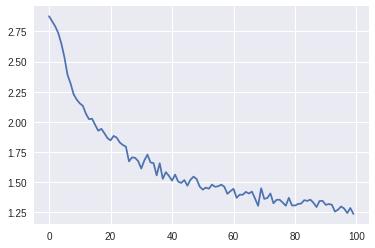

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating the Results
We’ll create a confusion matrix in order to see how the network performed on different categories. The bright spots off the main axis show the languages it guesses incorrectly.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


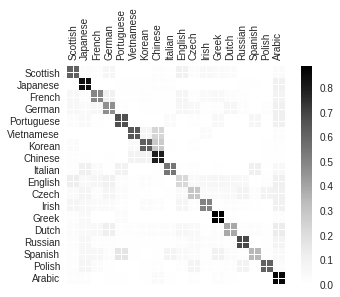

In [28]:
confusion = torch.zeros(no_of_languages, no_of_languages)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(no_of_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Predicting New Names
We’ll define a function that will take in a name and return the likely languages the name is from.

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Irfan')


> Irfan
(-0.81) Arabic
(-2.25) English
(-2.34) Scottish


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [32]:
predict('Mini')


> Mini
(-0.91) Chinese
(-1.17) Italian
(-2.60) Japanese


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
